In [9]:
from pyclustering.cluster.kmedoids import kmedoids
from collections import defaultdict
from sklearn.cluster import KMeans
from scipy.stats import hypergeom
from itertools import islice, product
from functools import partial

import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
sns.set()
DATA_DIRECTORY = "/home/clusterduck123/Desktop/git/supplements/data"

RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw_data"
PPI_DIRECTORY = f"{DATA_DIRECTORY}/PPI"
ANNOTATIONS_DIRECTORY = f"{DATA_DIRECTORY}/annotations"
MATRIX_DIRECTORY = f"{DATA_DIRECTORY}/matrix"
CLUSTERS_DIRECTORY = f"{DATA_DIRECTORY}/clusters"

name2string = {'tvd0':'TVD_0', 'tvd1':'TVD_1', 'tvd2':'TVD_2', 'tvd3':'TVD_3',
               'tvd0123':'TVD_{0123}', 'tijana':'Tijana',
               
               'GDV_euclidean'  :'GDV_{eucl}'  , 'GDV_zscore_euclidean'  :'GDV_{z-eucl}'  , 
               'GDV_cityblock'  :'GDV_{city}'  , 'GDV_zscore_cityblock'  :'GDV_{z-city}'  , 
               'GDV_seuclidean' :'GDV_{seucl}' , 'GDV_zscore_seuclidean' :'GDV_{z-seucl}' ,
               'GDV_cosine'     :'GDV_{cos}'   , 'GDV_zscore_cosine'     :'GDV_{z-cos}'   ,
               'GDV_correlation':'GDV_{cor}'   , 'GDV_zscore_correlation':'GDV_{z-cor}'   ,
               'GDV_sqeuclidean':'GDV_{eucl^2}', 'GDV_zscore_sqeuclidean':'GDV_{z-eucl^2}',
               'GDV_chebyshev'  :'GDV_{cheby}' , 'GDV_zscore_chebyshev'  :'GDV_{z-cheby}' ,
               'GDV_canberra'   :'GDV_{can}'   , 'GDV_zscore_canberra'   :'GDV_{z-can}'   ,
               'GDV_braycurtis' :'GDV_{bray}'  , 'GDV_zscore_braycurtis' :'GDV_{z-bray}'  ,
               'GDV_mahalanobis':'GDV_{mahala}', 'GDV_zscore_mahalanobis':'GDV_{z-mahala}',
               
               'GCV_euclidean'  :'GCV_{eucl}'  , 'GCV_zscore_euclidean'  :'GCV_{z-eucl}'  , 
               'GCV_cityblock'  :'GCV_{city}'  , 'GCV_zscore_cityblock'  :'GCV_{z-city}'  , 
               'GCV_seuclidean' :'GCV_{seucl}' , 'GCV_zscore_seuclidean' :'GCV_{z-seucl}' ,
               'GCV_cosine'     :'GCV_{cos}'   , 'GCV_zscore_cosine'     :'GCV_{z-cos}'   ,
               'GCV_correlation':'GCV_{cor}'   , 'GCV_zscore_correlation':'GCV_{z-cor}'   ,
               'GCV_sqeuclidean':'GCV_{eucl^2}', 'GCV_zscore_sqeuclidean':'GCV_{z-eucl^2}',
               'GCV_chebyshev'  :'GCV_{cheby}' , 'GCV_zscore_chebyshev'  :'GCV_{z-cheby}' ,
               'GCV_canberra'   :'GCV_{can}'   , 'GCV_zscore_canberra'   :'GCV_{z-can}'   ,
               'GCV_braycurtis' :'GCV_{bray}'  , 'GCV_zscore_braycurtis' :'GCV_{z-bray}'  ,
               'GCV_mahalanobis':'GCV_{mahala}', 'GCV_zscore_mahalanobis':'GCV_{z-mahala}',}

# Cluster independent variables

In [5]:
annotation_df = pd.read_csv(f"{ANNOTATIONS_DIRECTORY}/BioGRID-SGD_MF_sc.csv")
GO_population = {go_id for go_id in set(annotation_df.GO_ID) 
                           if 5 <= len(annotation_df[annotation_df.GO_ID == go_id]) <= 500}

annotation_df = annotation_df[annotation_df.GO_ID.isin(GO_population)]
# annotation_df = annotation_df[annotation_df.Level > -1]
# GO_population = set(annotation_df.GO_ID)

# Conversion dictionaries
int2GO = dict(enumerate(GO_population))
GO2int = dict(zip(int2GO.values(), int2GO.keys()))

GO2genes = {go_id:set(annotation_df.Systematic_ID[annotation_df.GO_ID == go_id])
                for go_id in GO_population}

gene2GO  = {gene :set(annotation_df.GO_ID[annotation_df.Systematic_ID == gene]) 
                for gene  in set(annotation_df.Systematic_ID)}

### Preparation

Let $N$ be the number of genes in the PPI.   
Each GO-term defines a 'state' in which $K$ proteins are annotated with this term; these are seen a _successes_.    
A given cluster defines an 'experiment', in which the number of draws, $n$, corresponds to the length of the cluster.    
The number of _successful draws_ $k$ corresponds to the number of annotated genes in the given cluster.

In [6]:
# List of success states
list_of_success_states = list(GO2genes.values())

# This will be our K, see below. Reshped to fit the shape of k 'array_of_observed_successes'
array_of_total_successes = np.array(list(map(len,list_of_success_states))).reshape(-1,1)

### Here we GO

In [7]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 100
alpha = [0.01, 0.05, 0.1]

hc_cluster_coverage = defaultdict(partial(np.ndarray, MAX_CLUSTERS-MIN_CLUSTERS))
mc_cluster_coverage = defaultdict(partial(np.ndarray, MAX_CLUSTERS-MIN_CLUSTERS))
lc_cluster_coverage = defaultdict(partial(np.ndarray, MAX_CLUSTERS-MIN_CLUSTERS))

hc_GO_coverage = defaultdict(partial(np.ndarray, MAX_CLUSTERS-MIN_CLUSTERS))
mc_GO_coverage = defaultdict(partial(np.ndarray, MAX_CLUSTERS-MIN_CLUSTERS))
lc_GO_coverage = defaultdict(partial(np.ndarray, MAX_CLUSTERS-MIN_CLUSTERS))

hc_gene_coverage = defaultdict(partial(np.ndarray, MAX_CLUSTERS-MIN_CLUSTERS))
mc_gene_coverage = defaultdict(partial(np.ndarray, MAX_CLUSTERS-MIN_CLUSTERS))
lc_gene_coverage = defaultdict(partial(np.ndarray, MAX_CLUSTERS-MIN_CLUSTERS))

In [8]:
all_distances = ['euclidean', 'cityblock', 'seuclidean', 'sqeuclidean', 
                 'cosine', 'correlation', 'chebyshev', 'canberra', 
                 'braycurtis', 'mahalanobis']

In [14]:
ALL_distances = [A+B for (A,B) in product(['GDV_', 'GDV_zscore_', 'GCV_', 'GCV_zscore_'], all_distances)]

In [46]:
METHOD = "kmedoids"

for distance in ['tijana']:
    print(distance)
    MATRIX_NAME = f"sc_BioGRID_{distance}"

    t1 = time.time()
    for i, n_clusters in enumerate(range(2, MAX_CLUSTERS)):

        with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'r') as f:
            clusters = list(map(str.split, f))

        list_of_experiments = list(map(set,clusters))

        # For each GO term and cluster we get an experiment 
        array_of_observed_successes = np.array([[len(draws & success_states) for draws in list_of_experiments]
                                            for success_states in list_of_success_states])


        N = sum(map(len,clusters))       # PPI size, i.e. number of all genes that appear in a cluster
        K = array_of_total_successes     # defined in section 'Preparation'
        n = list(map(len, clusters))     # cluster lengths
        k = array_of_observed_successes 

        # scipy has a really messed up nomeclature... 
        p_values_array = 1-hypergeom.cdf(k=k-1, M=N, N=n, n=K)
        p_values_df    = pd.DataFrame(p_values_array, index=GO_population)
        GO_index = p_values_df.index

        m = p_values_array.size

        hc_enrichment_df = p_values_df < alpha[0]/m
        mc_enrichment_df = p_values_df < alpha[1]/m
        lc_enrichment_df = p_values_df < alpha[2]/m

        # Calculate cluster coverage
        hc_cluster_coverage[distance][i] = sum(hc_enrichment_df.any())/n_clusters
        mc_cluster_coverage[distance][i] = sum(mc_enrichment_df.any())/n_clusters
        lc_cluster_coverage[distance][i] = sum(lc_enrichment_df.any())/n_clusters

        # Calculate GO-term coverage
        hc_GO_coverage[distance][i] = sum(hc_enrichment_df.any(axis=1))/len(GO_population)
        mc_GO_coverage[distance][i] = sum(mc_enrichment_df.any(axis=1))/len(GO_population)
        lc_GO_coverage[distance][i] = sum(lc_enrichment_df.any(axis=1))/len(GO_population)

        # Calculate gene coverage
        hc_gene_coverage[distance][i] = sum(1 for (i, cluster) in enumerate(clusters) for gene in cluster 
                                                if gene2GO.get(gene, set()) & set(GO_index[hc_enrichment_df[i]]))/N
        mc_gene_coverage[distance][i] = sum(1 for (i, cluster) in enumerate(clusters) for gene in cluster 
                                                if gene2GO.get(gene, set()) & set(GO_index[mc_enrichment_df[i]]))/N
        lc_gene_coverage[distance][i] = sum(1 for (i, cluster) in enumerate(clusters) for gene in cluster 
                                                if gene2GO.get(gene, set()) & set(GO_index[lc_enrichment_df[i]]))/N

        t2 = time.time()
        print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

tijana


In [49]:
plot_distances = ['tijana', 
                  'GCV_zscore_correlation', 
                  'GCV_zscore_cosine', 
                  'GCV_zscore_mahalanobis',
                  'GDV_mahalanobis',
                  'GDV_canberra',
                  'GDV_zscore_canberra']

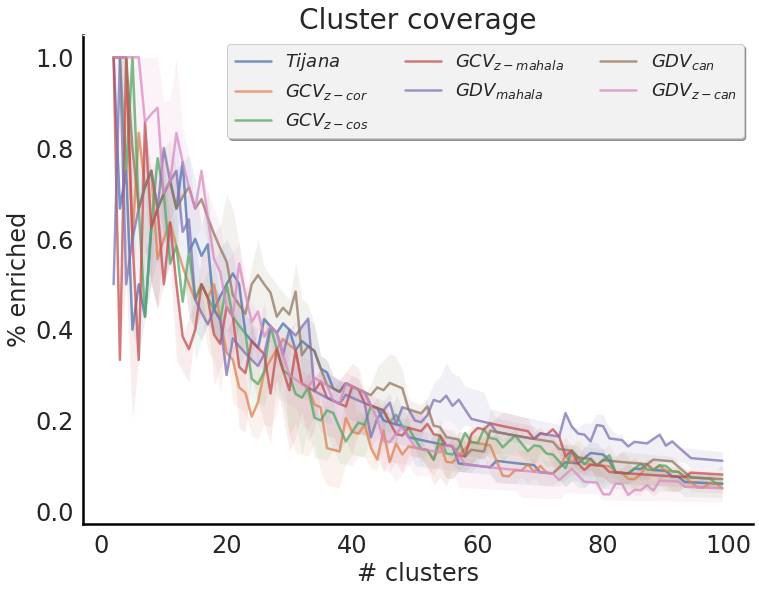

In [59]:
#Cluster coverage

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

Blues = iter(sns.color_palette("Blues",6)[::-1])
Reds  = iter(sns.color_palette("Reds", 6)[::-1])

for distance in plot_distances:
    
    if distance.startswith('GDV'):
        color = next(Reds)
    elif distance.startswith('GCV'):
        color = next(Blues)
    
    ax.plot(range(2,MAX_CLUSTERS), mc_cluster_coverage[distance], 
            label=f'${name2string[distance]}$', 
            linewidth=2.5,
#            color=color,
            alpha=0.75
           );
    
    ax.fill_between(range(2,MAX_CLUSTERS), 
                     hc_cluster_coverage[distance], 
                     lc_cluster_coverage[distance], 
                     alpha=0.1,
#                    color=color
                   );
    ax.set_title('Cluster coverage', fontsize=28)
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0], ncol=3);
fig.savefig(f"{DATA_DIRECTORY}/plots/dummy1.png")

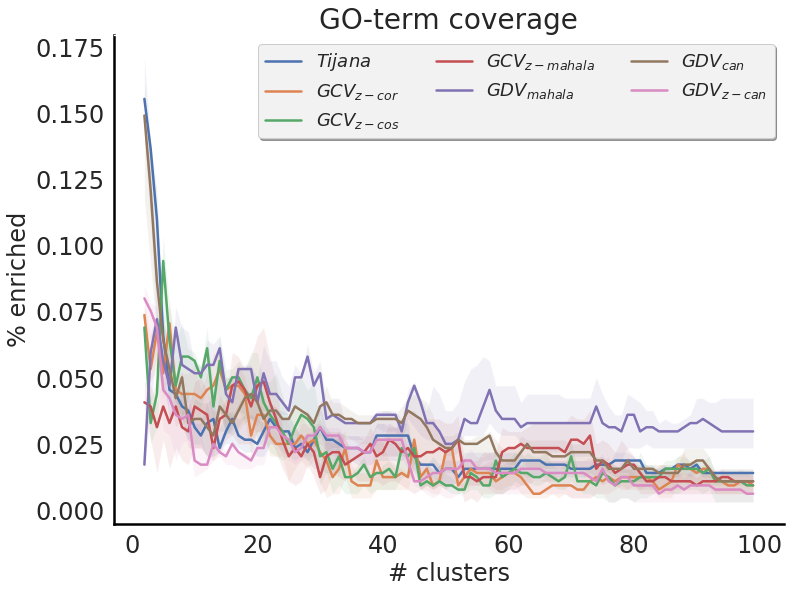

In [60]:
#Cluster coverage

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

for distance in plot_distances:
    
    ax.plot(range(2,MAX_CLUSTERS), mc_GO_coverage[distance], 
             label=f'${name2string[distance]}$', 
             linewidth=2.5);
    ax.fill_between(range(2,MAX_CLUSTERS), 
                     hc_GO_coverage[distance], 
                     lc_GO_coverage[distance], 
                     alpha=0.1);
    ax.set_title('GO-term coverage', fontsize=28)
    
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0], ncol=3);
fig.savefig(f"{DATA_DIRECTORY}/plots/dummy2.png")

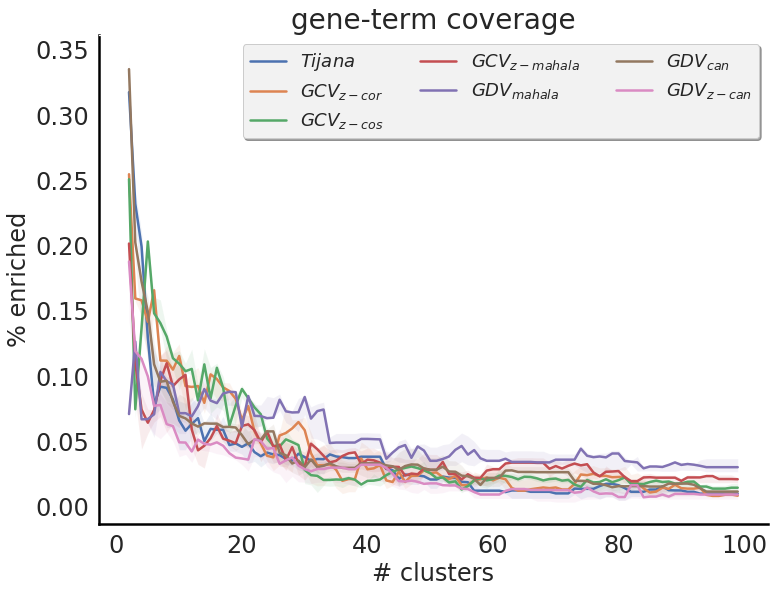

In [61]:
#Cluster coverage

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

for distance in plot_distances:
    
    ax.plot(range(2,MAX_CLUSTERS), mc_gene_coverage[distance], 
             label=f'${name2string[distance]}$', 
             linewidth=2.5);
    ax.fill_between(range(2,MAX_CLUSTERS), 
                     hc_gene_coverage[distance], 
                     lc_gene_coverage[distance], 
                     alpha=0.1);
    ax.set_title('gene-term coverage', fontsize=28)
    
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0], ncol=3);
fig.savefig(f"{DATA_DIRECTORY}/plots/dummy3.png")